## Классификация сервисов яндекс при помощи модели Random Forest

### Загрузим библиотеки

In [1]:
import pandas as pd

print("Pandas version: ", pd.__version__)

import sys  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.cross_validation import  cross_val_score



Pandas version:  1.4.4


In [2]:
current_path = ''

# current_path = 'iter-20230609/by_balabanov'
df_final_filename = f'data/df_final_4serv.csv'

dfFinal = pd.read_csv(df_final_filename)

print('df_final: ', dfFinal.shape)

df_final:  (8375, 40)


#### Посмотрим датасету в глаза

#### Удалим nan

In [3]:
dfFinal.dropna(axis=1,inplace=True)
dfFinal.shape

(8375, 20)

#### Выделим target и удалим колонки (по необходимости)

In [4]:
y = dfFinal['type']
drop_col = ['type','proto','diag_step_fiat','diag_step_biat','diag_steps']
X  = dfFinal.drop(columns=drop_col)

#### Разобьем данные на подопытные и проверочные

In [5]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=None)

#### Погуляем по случайному лесу

In [6]:
estimator = RandomForestClassifier()

##### ...со следующим набором параметров

In [7]:
parameters = {
    'n_estimators': [50, 200, 700],
    'max_features': ['sqrt', 'log2']
}

In [8]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 5,
    cv = 10,
    verbose=True
)

In [9]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 200, 700]},
             scoring='accuracy', verbose=True)

In [10]:
grid_search.best_estimator_

RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [11]:
predictions_RFC = grid_search.predict(X_test)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay)

In [13]:
def plot_confusion_matrix(y_test, prediction, model_name, index=["0", "1", "2", "3"], columns=["0", "1", "2", "3"]):
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index, columns)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, fmt='g', annot_kws={"size": 10})
    plt.title(model_name+'\nAccuracy:{0:.4f}'.format(accuracy_score(y_test, prediction)))
    plt.ylabel('True Label', fontsize=1)
    plt.show()


def display_confusion_matrix(y_test, prediction, display_labels=["0", "1", "2", "3"]):
    cm = confusion_matrix(y_test, prediction)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_display.plot()
    plt.show()


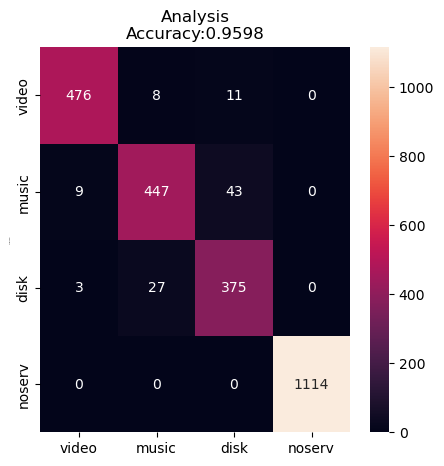

In [14]:
plot_confusion_matrix(y_test, predictions_RFC.round(), "Analysis", index=["video", "music", "disk", "noserv"], columns=["video", "music", "disk", "noserv"])

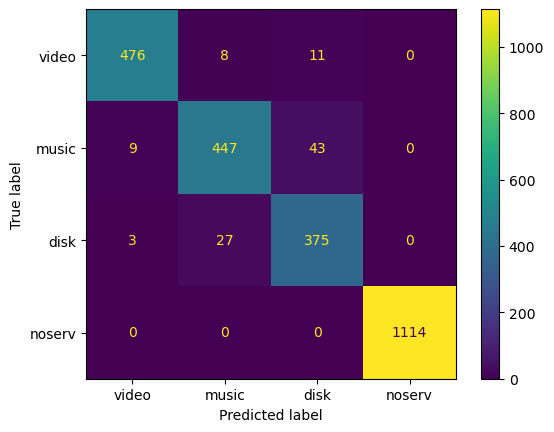

In [15]:
display_confusion_matrix(y_test, predictions_RFC.round(), display_labels=["video", "music", "disk", "noserv"])

In [16]:
feature_importances = grid_search.best_estimator_.feature_importances_ / 2
feature_importances = pd.DataFrame({'feature': list(X.columns),
                                    'importance': feature_importances}
                                  ).sort_values('importance', ascending = False)

feature_importances

,feature,importance
12,pktiat_1,0.126668
13,pktiat_2,0.084635
3,flow_packets_per_second,0.072921
10,tcp_retr_count,0.057071
5,b_min_pkt_size,0.039975
1,min_fiat,0.034027
4,f_min_pkt_size,0.033908
2,min_biat,0.033696
8,tcp_fin_count,0.010154
14,pktlen_1,0.005809
